## Import dependencies

In [1]:
import os
import sys 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from models.orthogonal_nn import *
from utils.rbs_gate import *

2025-02-05 23:55:24.372026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738770924.392346 1632645 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738770924.398535 1632645 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ModuleNotFoundError: No module named 'google.protobuf'

## Prepare dataset

In [2]:
# Expand the dimensions of the images to (28, 28, 1) to represent the grayscale channel explicitly
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Filter for only the classes 3 and 6
train_filter = np.where((y_train == 6) | (y_train == 3))
test_filter = np.where((y_test == 6) | (y_test == 3))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Use the first 500 images as the training set
x_train, y_train = x_train[:500], y_train[:500]
# Randomly sample 300 images from the remaining data as the validation set
x_val, y_val = x_test[500:800], y_test[500:800]

x_test, y_test = x_test[:300], y_test[:300]

# Rescale the images
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

train_images = np.expand_dims(x_train, -1)
test_images = np.expand_dims(x_test, -1)

def preprocess_images(images):
    # Center-crop to 24x24
    images_cropped = tf.image.central_crop(images, central_fraction=24/28)
    
    # Down-sample to 4x4
    images_downsampled = tf.image.resize(images_cropped, size=(4, 4), method=tf.image.ResizeMethod.BILINEAR)
    
    return images_downsampled

# Preprocess the train, validation, and test images
train_images = preprocess_images(train_images)
test_images= preprocess_images(test_images)

# Map the labels 3 -> 0 and 6 -> 1
y_train_binary = np.where(y_train == 3, 0, 1)
y_test_binary = np.where(y_test == 3, 0, 1)

# Convert the labels to one-hot encoded vectors
# train_labels = to_categorical(y_train_binary, 2)
# test_labels = to_categorical(y_test_binary, 2)

train_labels = y_train_binary
test_labels = y_test_binary
print("Shape of train labels:", train_labels.shape)
print("Shape of test labels:", test_labels.shape)

Shape of train labels: (500,)
Shape of test labels: (300,)


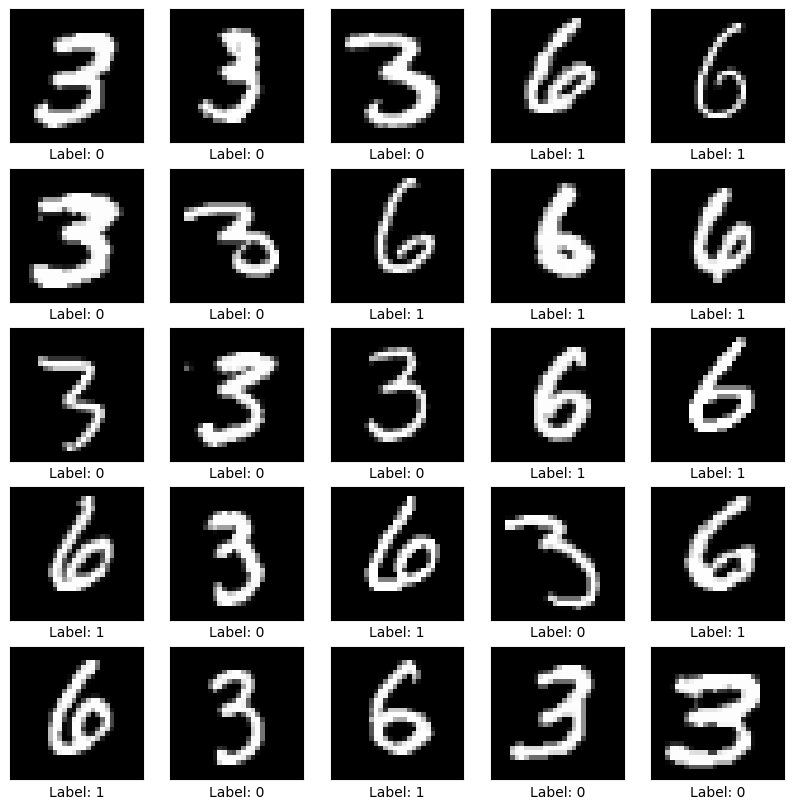

In [ ]:
import matplotlib.pyplot as plt
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    grid_size = 5
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

plot_images(x_train, train_labels)

## Training process

In [ ]:
# Define model and optimizer

# set random seed
random = 10
model = HybridModel(random)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Start training
history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=32,
    validation_data=(test_images, test_labels)
)

Epoch 1/20


Cause: Unable to locate the source code of <function _gcd_import at 0x756c0a397430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
16/16 [==============================] - 28s 474ms/step - loss: 0.7561 - accuracy: 0.4380 - auc: 0.4482 - val_loss: 0.7748 - val_accuracy: 0.3933 - val_auc: 0.4100
Epoch 2/20
16/16 [==============================] - 5s 301ms/step - loss: 0.7150 - accuracy: 0.4900 - auc: 0.5205 - val_loss: 0.7524 - val_accuracy: 0.4367 - val_auc: 0.4400
Epoch 3/20
16/16 [==============================] - 5s 300ms/step - loss: 0.6826 - accuracy: 0.5400 - auc: 0.5869 - val_loss: 0.7290 - val_acc

KeyboardInterrupt: 